In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [21]:
data = pd.read_csv('diabetes_logreg.csv')

In [22]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Outcome', axis=1), data['Outcome'], test_size=0.3, random_state=2006)

In [24]:
Xy_train = X_train.join(y_train)

Let's look at the relative frequency of outcomes.

In [25]:
y_train.value_counts()

0    356
1    181
Name: Outcome, dtype: int64

In [26]:
y_train.value_counts()/len(y_train)

0    0.662942
1    0.337058
Name: Outcome, dtype: float64

One initial way we might consider which factors are useful is to look at the mean values of various variables by outcome.

In [27]:
Xy_train.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.379213,109.544944,68.528090,20.123596,67.297753,30.216292,0.427888,31.367978
1,4.883978,141.104972,70.823204,22.110497,104.767956,35.093923,0.550713,37.270718


In [28]:
formula = 'Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age'
model = smf.logit(formula, Xy_train).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.460282
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit              Pseudo R-squared:   0.280     
Dependent Variable:     Outcome            AIC:                512.3429  
Date:                   2022-12-09 15:47   BIC:                550.9169  
No. Observations:       537                Log-Likelihood:     -247.17   
Df Model:               8                  LL-Null:            -343.18   
Df Residuals:           528                LLR p-value:        3.0719e-37
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         6.0000                                           
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept                -8.6020   0.8622 -9.9770 0.0000 -10.2919 -6.9122
Pregnancies               0.1066   0.0381  2.7996 0.0051   0.0320  0.1812
Glucose                   0.0365   0.0046  7.9947 0.0000   0.0276  0.0455
BloodPressure            -0.0155   0.0065 -2.3686 0.0179  -0.0283 -0.0027
SkinThickness            -0.0048   0.0085 -0.5691 0.5693  -0.0215  0.0118
Insulin                  -0.0009   0.0011 -0.7658 0.4438  -0.0031  0.0014
BMI                       0.0989   0.0182  5.4398 0.0000   0.0633  0.1346
DiabetesPedigreeFunction  0.7691   0.3599  2.1369 0.0326   0.0637  1.4745
Age                       0.0172   0.0116  1.4836 0.1379  -0.0055  0.0399
=========================================================================

"""

Let's trim some of those terms using backward elimination, focusing on BIC to get a nice svelte model.

In [29]:
formula = 'Outcome ~ Pregnancies + Glucose + BMI'
model = smf.logit(formula, Xy_train).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.473142
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.260     
Dependent Variable: Outcome          AIC:              516.1550  
Date:               2022-12-09 15:47 BIC:              533.2990  
No. Observations:   537              Log-Likelihood:   -254.08   
Df Model:           3                LL-Null:          -343.18   
Df Residuals:       533              LLR p-value:      2.1582e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept       -8.5015   0.7856 -10.8215 0.0000 -10.0413 -6.9617
Pregnancies      0.1240   0.0316   3.9174 0.0001   0.0619  0.1860
Glucose          0.0362   0.0041   8.8016 0.0000   0.0281  0.0442
BMI              0.0858   0.0164   5.2191 0.0000   0.0536  0.1181
=================================================================

"""

Ok, it's not great but it's ok. What do our residuals look like?

In [30]:
def plot_logreg_resids(model): 
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    sns.regplot(x=model.fittedvalues, y=model.resid_pearson, ax=ax[0],
                color='navy', line_kws={'color':'red'}, 
                marker='.', lowess=True
               )
    ax[0].plot([min(model.fittedvalues), max(model.fittedvalues)],
            [0,0], color='red', ls=':'
           )
    ax[0].set_xlabel('Linear Predictor Values')
    ax[0].set_ylabel('Studentized Pearson Residuals')
    ax[0].set_title('Studentized Pearson Residuals vs. Fitted Values')

    sns.regplot(x=model.fittedvalues, y=model.resid_dev, ax=ax[1],
                color='navy', line_kws={'color':'red'}, 
                marker='.', lowess=True
               )
    ax[1].plot([min(model.fittedvalues), max(model.fittedvalues)],
            [0,0], color='red', ls=':'
           )
    ax[1].set_xlabel('Linear Predictor Values')
    ax[1].set_ylabel('Deviance Residuals')
    ax[1].set_title('Deviance Residuals vs. Fitted Values')

    fig.tight_layout()
    plt.show()

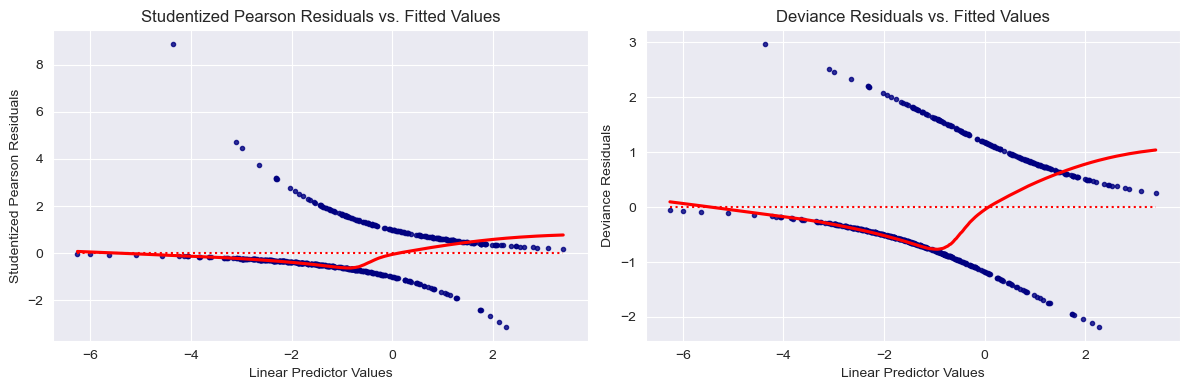

In [31]:
plot_logreg_resids(model)

Hmmm... those don't look great, but they aren't horrendous. Residuals are between -1 and 1. Let's see if we can improve them by applying transformations.

Of course, we can't transform the response variable now, so we'll have to work on the predictor variables.

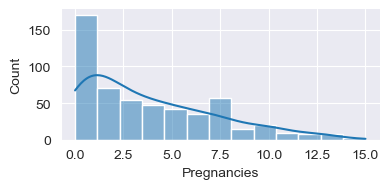

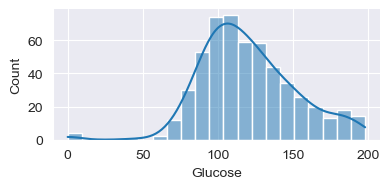

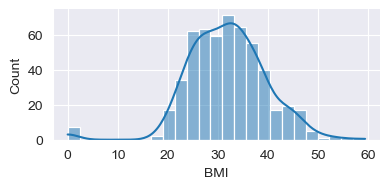

In [32]:
for col in ['Pregnancies','Glucose','BMI']:
    sns.displot(data=X_train, x=col, aspect=2, height=2, kde=True)
    plt.show()

Pregnancies is abnormal, we could transform that. Glucose... maybe? BMI looks fine. Note that there are come glucose measurements of 0 - we should check if those are missing values and considering excluding them from the model.

Let's use Box-Cox to consider transformations. Recall that data must be positive for Box-Cox, so I'll add a small amount to all values to get them above zero.

In [33]:
_, lmbda, ci = stats.boxcox(X_train['Pregnancies']+0.01, alpha=0.05)
print(lmbda, ci)

0.40465384987511205 (0.3586269331103481, 0.452111076852862)


I'll probably use a square root transformation on Pregnancies.

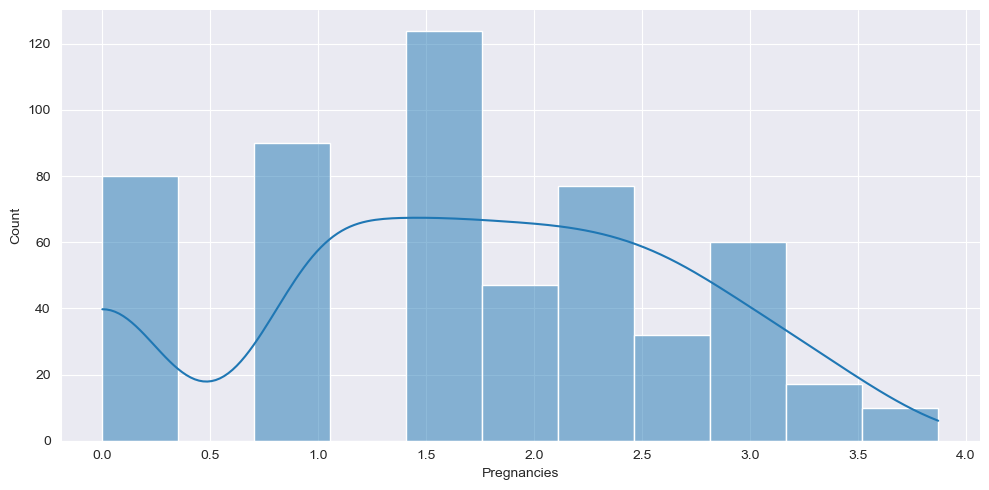

In [37]:
sns.displot(np.sqrt(X_train['Pregnancies']), aspect=2, kde=True)
plt.show()

In [34]:
_, lmbda, ci = stats.boxcox(X_train['Glucose']+0.01, alpha=0.05)
print(lmbda, ci)

0.9199301712409672 (0.8063026294696932, 1.0497197731096695)


Well, that doesn't look like it needs a transformation.

In [38]:
formula = 'Outcome ~ I(np.sqrt(Pregnancies)) + Glucose + BMI'
model = smf.logit(formula, Xy_train).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.477277
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit              Pseudo R-squared:   0.253     
Dependent Variable:     Outcome            AIC:                520.5952  
Date:                   2022-12-09 15:52   BIC:                537.7392  
No. Observations:       537                Log-Likelihood:     -256.30   
Df Model:               3                  LL-Null:            -343.18   
Df Residuals:           533                LLR p-value:        1.9627e-37
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         6.0000                                           
-------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept               -8.7367   0.8106 -10.7780 0.0000 -10.3255 -7.1479
I(np.sqrt(Pregnancies))  0.3691   0.1113   3.3151 0.0009   0.1509  0.5874
Glucose                  0.0364   0.0041   8.8649 0.0000   0.0283  0.0444
BMI                      0.0879   0.0165   5.3206 0.0000   0.0555  0.1203
=========================================================================

"""

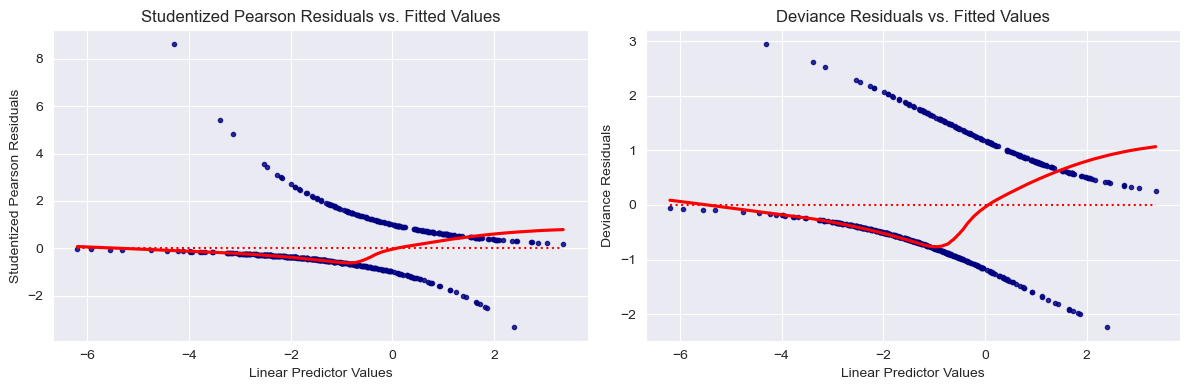

In [39]:
plot_logreg_resids(model)

It didn't improve much though, and our BIC actually went up. Let's go back to our non-transformed model.

In [40]:
formula = 'Outcome ~ Pregnancies + Glucose + BMI'
model = smf.logit(formula, Xy_train).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.473142
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.260     
Dependent Variable: Outcome          AIC:              516.1550  
Date:               2022-12-09 15:53 BIC:              533.2990  
No. Observations:   537              Log-Likelihood:   -254.08   
Df Model:           3                LL-Null:          -343.18   
Df Residuals:       533              LLR p-value:      2.1582e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept       -8.5015   0.7856 -10.8215 0.0000 -10.0413 -6.9617
Pregnancies      0.1240   0.0316   3.9174 0.0001   0.0619  0.1860
Glucose          0.0362   0.0041   8.8016 0.0000   0.0281  0.0442
BMI              0.0858   0.0164   5.2191 0.0000   0.0536  0.1181
=================================================================

"""

## How did it do?

In [41]:
pred = model.predict(X_test).apply(lambda xx: 1 if xx>=0.5 else 0)
print(confusion_matrix(y_test, pred))

[[124  20]
 [ 40  47]]


In [42]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       144
           1       0.70      0.54      0.61        87

    accuracy                           0.74       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.74      0.74      0.73       231



In [43]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

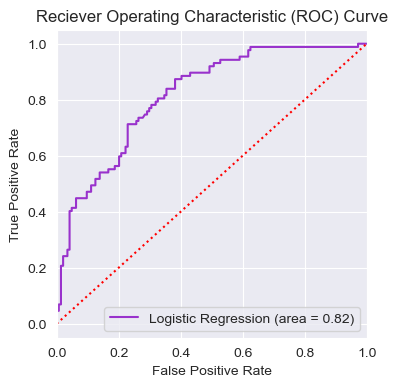

In [44]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, color='darkorchid',
        label=f'Logistic Regression (area = {logit_roc_auc:.2f})'
       )
ax.plot([0,1],[0,1], color='red', ls=':')
ax.set_xlim([0,1])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Reciever Operating Characteristic (ROC) Curve')
ax.legend()
plt.show()

Ok! That's actually a pretty decent classifier for this data. A neural network or some other fancy classifier could probably do better (with far worse interpretability), but this is a great baseline for those other classifier methods.

That's it for a brief introduction to Logistic Regression.